In [10]:
import os
import re
import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

# Path to your dataset directory (relative to the notebook location)
DATA_DIR = os.path.join("data", "2-25 Data")

# Columns expected in each CSV
TIME_COL = "Time (s)"
SENSOR_COLS = ["Temporalis", "Buccinator", "Suprahyoid", "Massater"]

# Optional: set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [11]:
SENTENCE_MAP = {
    1: "The boy was there when the sun rose.",
    2: "A rod is used to catch pink salmon.",
    3: "The source of the huge river is the clear spring.",
    4: "Kick the ball straight and follow through.",
    5: "Help the woman get back to her feet.",
}

def parse_sentence_id(filename: str) -> int:
    """
    Extract sentence ID from filename like 'AntList2Sent3-4.csv' -> 3
    """
    base = os.path.basename(filename)
    m = re.search(r"Sent(\d+)", base)
    if not m:
        raise ValueError(f"Could not parse sentence ID from filename: {base}")
    return int(m.group(1))

def parse_recording_id(filename: str) -> int:
    """
    Extract recording ID from filename like 'AntList2Sent3-4.csv' -> 4
    """
    base = os.path.basename(filename)
    m = re.search(r"-(\d+)\.csv$", base)
    if not m:
        raise ValueError(f"Could not parse recording ID from filename: {base}")
    return int(m.group(1))

In [12]:
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print(f"Found {len(csv_files)} CSV files in: {DATA_DIR}")

# Print a few examples
for f in csv_files[:5]:
    sid = parse_sentence_id(f)
    rid = parse_recording_id(f)
    print(os.path.basename(f), "-> sentence", sid, "| recording", rid)

# Validate distribution (should be 5 per sentence)
counts = {}
for f in csv_files:
    sid = parse_sentence_id(f)
    counts[sid] = counts.get(sid, 0) + 1
counts

Found 25 CSV files in: data/2-25 Data
AntList2Sent1-1.csv -> sentence 1 | recording 1
AntList2Sent1-2.csv -> sentence 1 | recording 2
AntList2Sent1-3.csv -> sentence 1 | recording 3
AntList2Sent1-4.csv -> sentence 1 | recording 4
AntList2Sent1-5.csv -> sentence 1 | recording 5


{1: 5, 2: 5, 3: 5, 4: 5, 5: 5}

In [13]:
example_path = csv_files[0]
df_ex = pd.read_csv(example_path)
print("Example file:", os.path.basename(example_path))
df_ex.head()

Example file: AntList2Sent1-1.csv


,Time (s),Temporalis,Buccinator,Suprahyoid,Massater
0,0.001787,19,24,42,22
1,0.002300,19,24,43,23
2,0.002800,19,23,43,22
3,0.003305,19,23,43,23
4,0.017227,19,23,43,23


In [14]:
def load_and_clean_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Ensure required columns exist
    missing = [c for c in [TIME_COL] + SENSOR_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    # Drop rows with NaN in required columns
    df = df[[TIME_COL] + SENSOR_COLS].dropna().reset_index(drop=True)

    # Convert to numeric (in case strings appear)
    for c in [TIME_COL] + SENSOR_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    return df

In [15]:
def extract_features_from_df(df: pd.DataFrame) -> np.ndarray:
    feats = []

    for col in SENSOR_COLS:
        x = df[col].to_numpy(dtype=float)

        # Optional per-recording normalization (helps with session-to-session differences)
        # If std==0 (flat signal), avoid division by zero.
        x_std = np.std(x)
        if x_std > 1e-8:
            x = (x - np.mean(x)) / x_std
        else:
            x = x - np.mean(x)

        # Feature set (simple + effective for EMG)
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x**2)),        # RMS
            np.sum(x**2),                  # Energy
            np.mean(np.abs(np.diff(x))),   # Activity / roughness
            np.mean(np.abs(x)),            # Mean absolute value
        ])

    return np.array(feats, dtype=float)

def extract_features(path: str) -> np.ndarray:
    df = load_and_clean_csv(path)
    return extract_features_from_df(df)

In [16]:
WINDOW_SIZE = 200   # samples per window
STEP_SIZE = 100     # overlap

def extract_window_features(df):
    X_windows = []

    signals = df[SENSOR_COLS].values

    for start in range(0, len(signals) - WINDOW_SIZE, STEP_SIZE):
        window = signals[start:start+WINDOW_SIZE]

        feats = []

        for i in range(window.shape[1]):
            x = window[:, i]

            x = (x - np.mean(x)) / (np.std(x) + 1e-8)

            feats.extend([
                np.mean(x),
                np.std(x),
                np.sqrt(np.mean(x**2)),   # RMS
                np.sum(x**2),
                np.mean(np.abs(np.diff(x)))
            ])

        X_windows.append(feats)

    return np.array(X_windows)

In [17]:
X = []
y = []

for f in csv_files:
    sid = parse_sentence_id(f)

    df = load_and_clean_csv(f)
    windows = extract_window_features(df)

    for w in windows:
        X.append(w)
        y.append(sid)

X = np.array(X)
y = np.array(y)

print("Dataset size:", X.shape)

Dataset size: (25, 20)


In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_SEED,
        class_weight=None
    ))
])

fold_accuracies = []
all_true = []
all_pred = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    acc = accuracy_score(y_test, preds)
    fold_accuracies.append(acc)

    all_true.extend(y_test.tolist())
    all_pred.extend(preds.tolist())

    print(f"Fold {fold} accuracy: {acc:.3f}")

print("\nMean accuracy:", float(np.mean(fold_accuracies)))
print("Std accuracy:", float(np.std(fold_accuracies)))

Fold 1 accuracy: 0.200
Fold 2 accuracy: 0.200
Fold 3 accuracy: 0.400
Fold 4 accuracy: 0.200
Fold 5 accuracy: 0.200

Mean accuracy: 0.24
Std accuracy: 0.08


              precision    recall  f1-score   support

       Sent1       0.00      0.00      0.00         5
       Sent2       0.00      0.00      0.00         5
       Sent3       0.50      0.40      0.44         5
       Sent4       0.00      0.00      0.00         5
       Sent5       0.80      0.80      0.80         5

    accuracy                           0.24        25
   macro avg       0.26      0.24      0.25        25
weighted avg       0.26      0.24      0.25        25



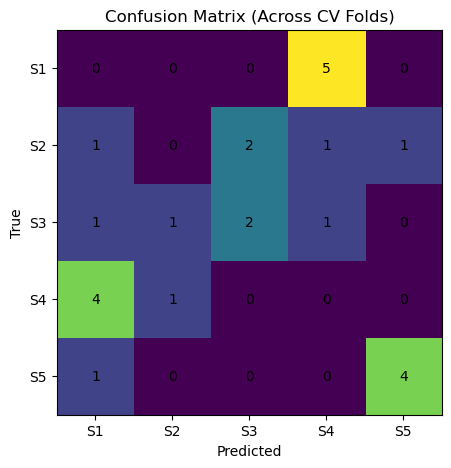

In [19]:
labels = [1,2,3,4,5]
cm = confusion_matrix(all_true, all_pred, labels=labels)

print(classification_report(all_true, all_pred, labels=labels, target_names=[f"Sent{i}" for i in labels]))

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([f"S{i}" for i in labels])
ax.set_yticklabels([f"S{i}" for i in labels])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Across CV Folds)")

for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.show()